<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/01_General/SIREN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIREN

## 0. Info

### Paper
* title: Implicit Neural Representations with Periodic Activation Functions
* author: Vincent Sitzmann et al.
* url: https://arxiv.org/abs/2006.09661

### Features
* None

### Reference
* https://github.com/vsitzmann/siren

## 1. Setup

In [1]:
import os
import requests
import easydict
from glob import glob
from PIL import Image
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [2]:
cfg = easydict.EasyDict(
    device = 'cuda',
)

## 2. Model

In [3]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30.):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                val = 1 / self.in_features
            else:
                val = np.sqrt(6 / self.in_features) / self.omega_0
            self.linear.weight.uniform_(-val, val)
    
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

In [4]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, num_hidden_layers, out_features, linear_final=False, init_omega_0=30., hidden_omega_0=30.):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=init_omega_0))
        for _ in range(num_hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, omega_0=hidden_omega_0))

        if linear_final:
            final = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                val = np.sqrt(6 / out_features) / hidden_omega_0
                final.weight.uniform_(-val, val)
        else:
            final = SineLayer(hidden_features, out_features, omega_0=hidden_omega_0)
        self.net.append(final)
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        return self.net(coords), coords

In [5]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def divergence(y, x):
    div = 0.
    for i in range(y.size(-1)):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def create_mgrid(size, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=size)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

## 3. Image Fitting

In [6]:
def prepare(img, img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    rgbs = transform(img).permute(1, 2, 0).view(-1, 3)
    coords = create_mgrid(img_size)
    return coords, rgbs

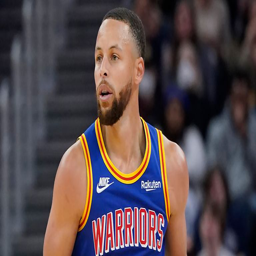

In [7]:
img_size = 256
img_url = 'https://e0.365dm.com/22/03/768x432/skysports-stephen-curry-golden-state-warriors_5714106.jpg?20220321112946'
img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
img.resize((img_size, img_size))

In [8]:
coords, rgbs = prepare(img, img_size)
coords, rgbs = coords.to(cfg.device), rgbs.to(cfg.device)
coords.shape, rgbs.shape

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([65536, 2]), torch.Size([65536, 3]))

In [9]:
siren = Siren(in_features=2, out_features=3, hidden_features=256, num_hidden_layers=5, linear_final=True).to(cfg.device)
optim = torch.optim.Adam(siren.parameters(), lr=1e-4)

In [10]:
num_training_steps = 3000

pbar = tqdm(range(num_training_steps))
for st in pbar:
    preds, _ = siren(coords)
    loss = F.mse_loss(preds, rgbs)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({'loss': loss.item()})

  0%|          | 0/3000 [00:00<?, ?it/s]

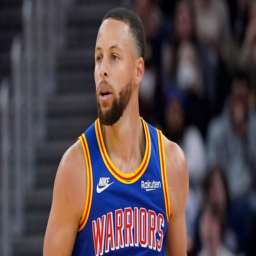

In [11]:
img_preds = preds.cpu().view(img_size, img_size, -1).detach()
img_preds = (img_preds * 128) + 128
img_preds = img_preds.clip(0, 256).type(torch.uint8).numpy()
Image.fromarray(img_preds)